In [ ]:
!pip install python-binance
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.7 MB/s eta 0:00:00


In [ ]:
from binance.client import Client
import pandas as pd


api_key = 'RQFQaWE49gAGwVP6EtaVELNkcYbrMGmSMZ3mGL9v8mkthaIIbObc9sv4sdMT0J7A'
api_secret = 'x2rYicDbjnZclgBdgUNaeLIZgzWn2hrj84vq4NSJH4iPIYraxKsA6kSJ7UjZH1ii'

client = Client(api_key, api_secret, tld='us')



client = Client(api_key, api_secret, tld='us')


symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_30MINUTE
start_date = "2 years ago UTC"


klines = client.get_historical_klines(symbol, interval, start_date)


columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume',
           'close_time', 'quote_asset_volume', 'number_of_trades',
           'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
df = pd.DataFrame(klines, columns=columns)


df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)

df.to_csv('binance_2years_30min.csv', index=False)
print("Данные сохранены в 'binance_2years_30min.csv'")

Данные сохранены в 'binance_2years_30min.csv'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import tensorflow as tf

def prepare_data(df, look_back=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['close']])

    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:i+look_back])
        y.append(scaled_data[i+look_back])

    return np.array(X), np.array(y), scaler

In [ ]:
def create_lstm_model(look_back=60):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

def train_and_evaluate_model(X, y, scaler, model_path='bitcoin_price_prediction_model.h5'):
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = create_lstm_model(X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )


    predictions = model.predict(X_test)


    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)

    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')


    plt.figure(figsize=(15,7))
    y_test_original = scaler.inverse_transform(y_test)
    predictions_original = scaler.inverse_transform(predictions)

    plt.plot(df.index[-len(y_test_original):], y_test_original, label='Actual Price', color='blue')
    plt.plot(df.index[-len(predictions_original):], predictions_original, label='Predicted Price', color='red')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


    model.save(model_path)
    print(f'Модель сохранена в {model_path}')

    return model, history

In [ ]:
def predict_next_prices(df, model, scaler, look_back=60, num_predictions=30):

    last_sequence = df[['close']].tail(look_back)
    scaled_sequence = scaler.transform(last_sequence)


    input_sequence = scaled_sequence.reshape((1, look_back, 1))


    predicted_prices = []
    for _ in range(num_predictions):
        next_price_scaled = model.predict(input_sequence)
        next_price = scaler.inverse_transform(next_price_scaled)[0][0]
        predicted_prices.append(next_price)

        input_sequence = np.roll(input_sequence, -1)
        input_sequence[0, -1, 0] = next_price_scaled[0][0]

    return predicted_prices


def bitcoin_price_prediction(data_path):

    df = pd.read_csv(data_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    look_back = 60
    X, y, scaler = prepare_data(df, look_back)

    model, history = train_and_evaluate_model(X, y, scaler)

    predicted_prices = predict_next_prices(df, model, scaler)

    print("\nПредсказанные цены на следующие 30 периодов:")
    for i, price in enumerate(predicted_prices, 1):
        print(f"Период {i}: {price:.2f}")

    return model, history, predicted_prices

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 53s 55ms/step - loss: 0.0028 - val_loss: 1.0386e-04
Epoch 2/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 52s 59ms/step - loss: 2.6713e-04 - val_loss: 0.0022
Epoch 3/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step - loss: 2.7984e-04 - val_loss: 0.0016
Epoch 4/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - loss: 2.6849e-04 - val_loss: 2.6597e-04
Epoch 5/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - loss: 2.8048e-04 - val_loss: 3.6883e-04
Epoch 6/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 51s 58ms/step - loss: 2.5272e-04 - val_loss: 3.2391e-04
Epoch 7/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - loss: 2.7982e-04 - val_loss: 5.9491e-04
Epoch 8/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 51s 58ms/step - loss: 2.6297e-04 - val_loss: 7.9590e-05
Epoch 9/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - loss: 2.4999e-04 - val_loss: 3.1840e-04
Epoch 10/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - loss: 2.5705e-04 - val_loss: 3.2148e-04
Epoch 11/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - loss:

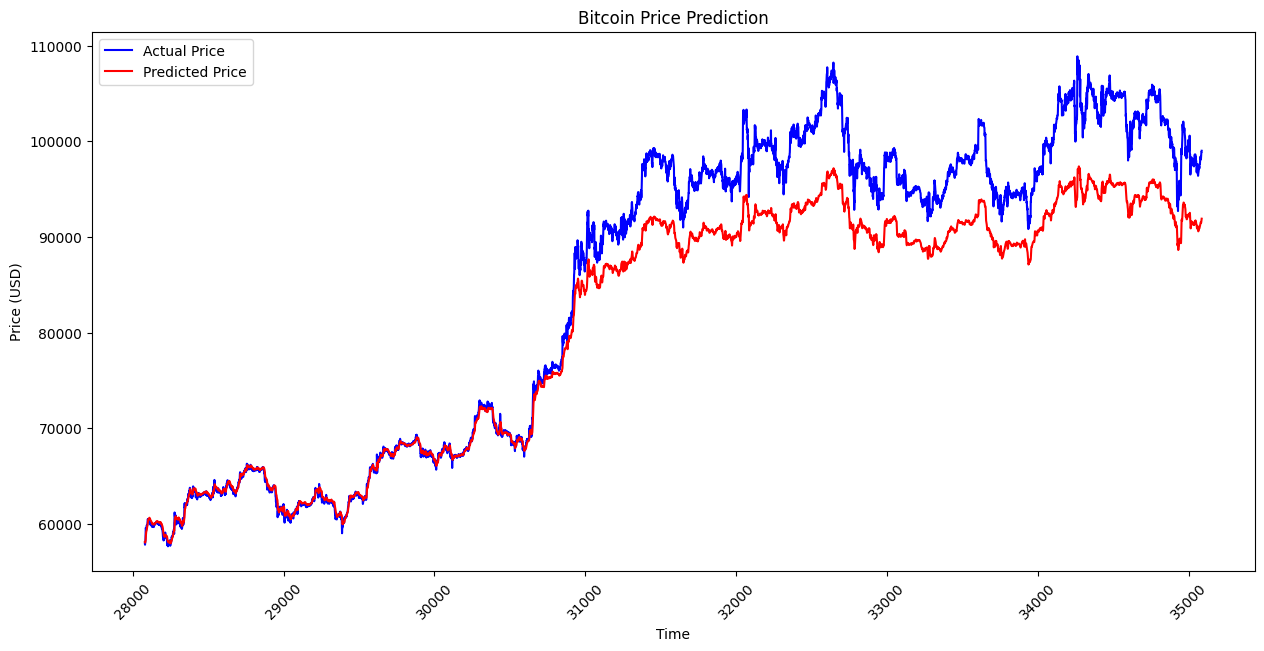

Модель сохранена в bitcoin_price_prediction_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/st

In [ ]:
model, history, predicted_prices = bitcoin_price_prediction('binance_2years_30min.csv')

In [ ]:
 plt.figure(figsize=(15,7))
    y_test_original = scaler.inverse_transform(y_test)
    predictions_original = scaler.inverse_transform(predictions)

    plt.plot(df.index[-len(y_test_original):], y_test_original, label='Actual Price', color='blue')
    plt.plot(df.index[-len(predictions_original):], predictions_original, label='Predicted Price', color='red')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def plot_predictions(df, y_test, predictions, scaler):
    import matplotlib.dates as mdates

    plt.figure(figsize=(15, 7))
    y_test_original = scaler.inverse_transform(y_test)
    predictions_original = scaler.inverse_transform(predictions)

    plt.plot(df.index[-len(y_test_original):], y_test_original, label='Actual Price', color='blue')
    plt.plot(df.index[-len(predictions_original):], predictions_original, label='Predicted Price', color='red')

    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    plt.show()


In [ ]:
plot_predictions(df, y_test, predictions, scaler)


NameError: name 'y_test' is not defined

In [ ]:
from binance.client import Client
import pandas as pd
from datetime import datetime, timedelta

# Вставьте API-ключи
api_key = 'RQFQaWE49gAGwVP6EtaVELNkcYbrMGmSMZ3mGL9v8mkthaIIbObc9sv4sdMT0J7A'
api_secret = 'x2rYicDbjnZclgBdgUNaeLIZgzWn2hrj84vq4NSJH4iPIYraxKsA6kSJ7UjZH1ii'

client = Client(api_key, api_secret, tld='us')


# Определяем даты
end_date = (datetime.utcnow() - timedelta(days=2*365)).strftime("%Y-%m-%d")  # Конец тестового периода (2 года назад)
start_date = (datetime.utcnow() - timedelta(days=2*365 + 5*30)).strftime("%Y-%m-%d")  # Начало тестового периода (2 года + 5 месяцев назад)

# Параметры для загрузки
symbol = 'BTCUSDT'  # Торговая пара
interval = Client.KLINE_INTERVAL_30MINUTE  # Интервал 30 минут

# Загрузка исторических данных
klines = client.get_historical_klines(symbol, interval, start_date, end_date)

# Преобразуем в DataFrame
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume',
           'close_time', 'quote_asset_volume', 'number_of_trades',
           'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
df_test = pd.DataFrame(klines, columns=columns)

# Преобразуем timestamp и числовые данные
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'], unit='ms')
df_test[['open', 'high', 'low', 'close', 'volume']] = df_test[['open', 'high', 'low', 'close', 'volume']].astype(float)

# Сохраняем в CSV
df_test.to_csv('binance_5months_before_training.csv', index=False)
print(f"Данные за 5 месяцев ({start_date} — {end_date}) сохранены в 'binance_5months_before_training.csv'")


Данные за 5 месяцев (2022-09-09 — 2023-02-06) сохранены в 'binance_5months_before_training.csv'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def load_and_predict(train_data_path, test_data_path, model_path='bitcoin_price_prediction_model.h5', look_back=60):
    try:
        model = load_model(
            model_path,
            custom_objects={
                'mse': tf.keras.losses.MeanSquaredError(),
                'mae': tf.keras.losses.MeanAbsoluteError()
            }
        )
        print(f"Model uplouded from  {model_path}")
    except Exception as e:
        print(f"Error uplouding {e}")
        return None, None

    try:
        df_train = pd.read_csv(train_data_path)
        df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
        df_train.set_index('timestamp', inplace=True)

        df_test = pd.read_csv(test_data_path)
        df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
        df_test.set_index('timestamp', inplace=True)
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None, None

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_train[['close']])

    def prepare_data_for_prediction(df, look_back):
        data = df[['close']].values
        scaled_data = scaler.transform(data)

        X = []
        for i in range(len(scaled_data) - look_back):
            X.append(scaled_data[i:i+look_back])

        return np.array(X), scaled_data

    X_input, full_scaled_data = prepare_data_for_prediction(df_test, look_back)

    if len(X_input) == 0:
        print("Недостаточно данных для прогнозирования")
        return None, None

    X_input = X_input.reshape((X_input.shape[0], X_input.shape[1], 1))

    try:
        predictions_scaled = model.predict(X_input)

        predictions = scaler.inverse_transform(predictions_scaled)

        plt.figure(figsize=(15,7))

        actual_prices = df_test['close'].values[look_back:len(predictions)+look_back]

        plt.plot(actual_prices, label='Actual Price', color='blue')
        plt.plot(predictions, label='Predicted Price', color='red')
        plt.title('Comparison of Actual and Predicted Bitcoin Prices')
        plt.xlabel('Time')
        plt.ylabel('Price(USD)')
        plt.legend()
        plt.show()

        mse = mean_squared_error(actual_prices, predictions)
        mae = mean_absolute_error(actual_prices, predictions)
        mape = mean_absolute_percentage_error(actual_prices, predictions)

        print("\nPrediction Accuracy Metrics:")
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")

        return predictions, actual_prices

    except Exception as e:
        print(f"Error: {e}")
        return None, None

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Model uplouded from  bitcoin_price_prediction_model.h5
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


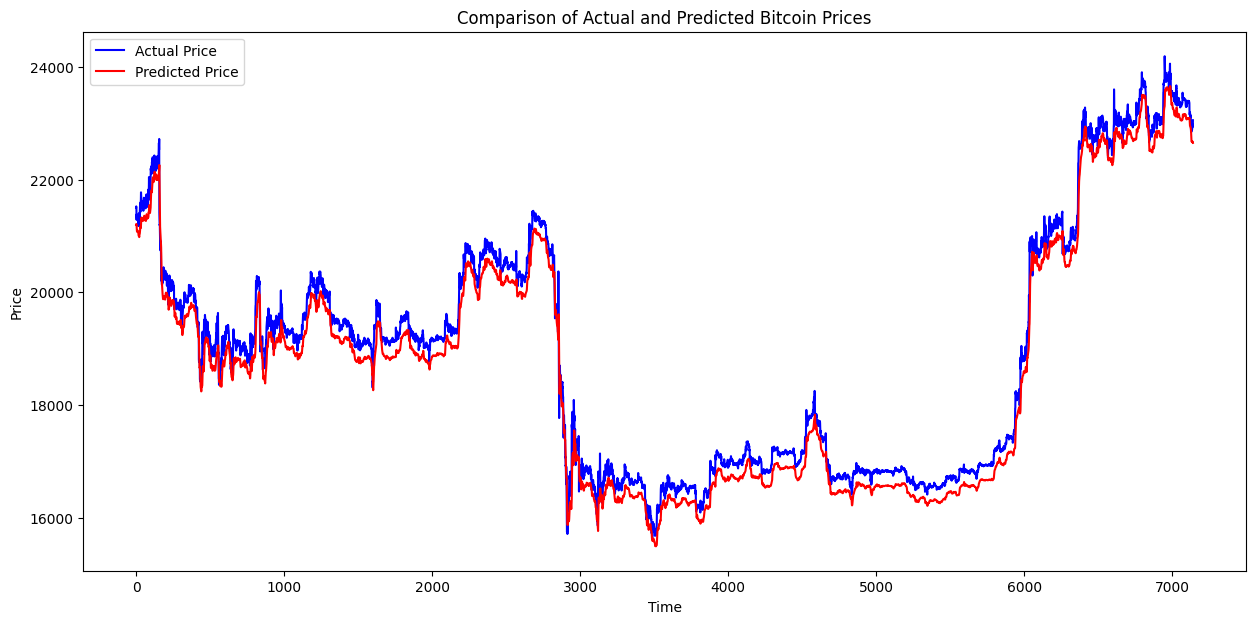


Prediction Accuracy Metrics:
Mean Squared Error (MSE): 88870.8159992449
Mean Absolute Error (MAE): 280.6128625630164
Mean Absolute Percentage Error (MAPE): 1.491730642154404%


In [ ]:
result = load_and_predict(
    train_data_path='binance_2years_30min.csv',
    test_data_path='binance_5months_before_training.csv'
)